<h1>Final Project: Seinfeld - Social Network Analysis</h1>

<h3> DATA 620 Web Analytics, CUNY Spring 2018 </h3>

Team: Andy Carson, Nathan Cooper, Walt Wells

Final Project link (notebook, videos, proposal): https://github.com/wwells/CUNY_DATA_620_GROUP/tree/master/Final_Project

<h2>Project Solution: Social Network Analysis</h2>

What does <i>Seinfeld</i> look like when analyzed using social networks?  What are the relationships between cast, characters, directors, and writers like?  How do these change over the seasons?  This will be explored below.


<h3> Analysis </h3>

<ol>
    <li>SNA of Actors / Characters by Season</li>
   
    <li>SNA of Character by Scene Number (scenes together)</li>
   
    <li>SNA of Directors by Season</li>
        
    <li>SNA of Writers by Season</li>
   
    <li>SNA of writers, directors, and cast</li>
    
</ol>



In [388]:
#import packages
import networkx as nx #note: this is version 2.1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite as bi
import math
import re
from IPython.display import Image

plt.figure(figsize = (17,8))
% matplotlib inline

<h2> Read In Data</h2>

Pull in pre-processed and cleaned data from GitHub. There is data about the:
<ul>
    <li>actor/character and season/episode (SEID)</li>
    <li>dialogue by Character, SEID, and scene, and a subset of this data to exclude one-offs</li>
    <li>director and SEID</li>
    <li>writers and SEID</li>
</ul>

We will use this data for our analysis.

In [389]:
#read in data
sf_cast = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Cast.csv")
sf_dialogue = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Dialogue.csv")
sf_dialgoue_sub = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_DialogueSUBSET.csv")
sf_metadata = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Metadata.csv")
sf_writers = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Writers.csv")

In [390]:
sf_cast.head(5)

,Actor,Character,SEID
0,Jerry Seinfeld,Jerry Seinfeld,S01E00
1,Jason Alexander,George Costanza,S01E00
2,Michael Richards,Kessler,S01E00
3,Lee Garlington,Claire,S01E00
4,Pamela Brull,Laura,S01E00


In [391]:
sf_dialogue.head(5)

,Character,Dialogue,DialogueIndex,SEID,SceneNum
0,JERRY,Do you know what this is all about? Do you kno...,1,S01E00,S01E00_1
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1,S01E00,S01E00_2
2,GEORGE,Are you through?,2,S01E00,S01E00_2
3,JERRY,"You do of course try on, when you buy?",3,S01E00,S01E00_2
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",4,S01E00,S01E00_2


In [392]:
sf_dialgoue_sub.head(5)

,Character,Dialogue,DialogueIndex,SEID,SceneNum
0,JERRY,Do you know what this is all about? Do you kno...,1,S01E00,S01E00_1
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1,S01E00,S01E00_2
2,GEORGE,Are you through?,2,S01E00,S01E00_2
3,JERRY,"You do of course try on, when you buy?",3,S01E00,S01E00_2
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",4,S01E00,S01E00_2


In [393]:
sf_metadata.head(5)

,AirDate,Director,Episode,SEID,Season,Title
0,"July 5, 1989",Art Wolff,1,S01E00,1,"Good News, Bad News"
1,"May 31, 1990",Tom Cherones,1,S01E01,1,The Stakeout
2,"June 7, 1990",Tom Cherones,2,S01E02,1,The Robbery
3,"June 14, 1990",Tom Cherones,3,S01E03,1,Male Unbonding
4,"June 21, 1990",Tom Cherones,4,S01E04,1,The Stock Tip


In [394]:
sf_writers.head(5)

,Writers,SEID
0,Larry David,S01E00
1,Jerry Seinfeld,S01E00
2,Larry David,S01E01
3,Jerry Seinfeld,S01E01
4,Matt Goldman,S01E02


<h2>Functions </h2>

Below are functions used in cleaning,transforming, and visualizing the social network data.

In [395]:
def centrality_measures(g):
    print "Number of Nodes:"
    print g.number_of_nodes()
    print
    
    print "Number of Edges:"
    print g.number_of_edges()
    print
    
    degree = nx.degree(g)
    degree = dict(list(degree))
    sort_degree = sorted(degree.iteritems(), key=lambda(k,v): (-v,k))
    print "Degree:"
    print sort_degree[0:10]
    print
    
    closeness = nx.closeness_centrality(g)
    print "Closeness:"
    print sorted(closeness.iteritems(), key=lambda(k,v): (-v,k))[0:10]
    print
    
    betweenness = nx.betweenness_centrality(g)
    print "Betweenness:"
    print sorted(betweenness.iteritems(), key=lambda(k,v): (-v,k))[0:10]
    print
    
    eigenvector = nx.eigenvector_centrality(g)
    print "Eigenvector:"
    print sorted(eigenvector.iteritems(), key=lambda(k,v): (-v,k))[0:10]
    print
    
    pagerank = nx.pagerank(g)
    print "Pagerank:"
    print sorted(pagerank.iteritems(), key=lambda(k,v): (-v,k))[0:10]

In [396]:
def make_draw_graph(graphName, node_values,df, labels):
    #make graph
    g = nx.Graph(name = graphName)
    
    #get nodes
    g.add_nodes_from(node_values)
    
    #get edges
    edges_tuples = [tuple(x) for x in df.values]
    g.add_weighted_edges_from(edges_tuples)
    
    #weight the data for edge width and coloring.  Code borrowed and modified from SNA.
    weights = [float(edata['weight']) for f, t, edata in g.edges(data=True)]
    
    #draw graph
    nx.draw_spring(g, with_labels=labels, width = weights, edge_color = weights)
    
    return g
    

In [397]:
#####
## islands method
# taken from SNA chp 4 pg 64.  Modified appropriately.
########

def trim_edges(g, weight = 1):
    edges = []
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight']> weight:
            x = float(edata['weight'])
            edges.append((f,to,x))
    g2.add_weighted_edges_from(edges)
    return g2


def island_method(g, iterations=5):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    
    #size of step
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

In [398]:
def print_island_info(island):
    print "Threshold, Nodes, Edges, Number of Connected Components"
    for i in island:
        print i[0], nx.number_of_nodes(i[1]), nx.number_of_edges(i[1]), nx.number_connected_components(i[1])

In [399]:
def show_island_graphs(g_island,threshold,labels):
    g_weights = [math.log(float(edata['weight'])) for f, t, edata in g_island[threshold][1].edges(data=True)]
    nx.draw_spring(g_island[threshold][1], width=g_weights, edge_color=g_weights, with_labels=labels)

In [400]:
def make_draw_projected_graph(g, labels):
    weights_graph = [float(edata['weight']) for f, t, edata in g.edges(data=True)]
    nx.draw_spring(g, width=weights_graph, edge_color=weights_graph, with_labels=labels)

In [401]:
def character_scene_graph(sf_dialgoue_sub_group_final,season_num, Episode, scene, label):
    character_scene_sub = sf_dialgoue_sub_group_final[sf_dialgoue_sub_group_final['season']==season_num]
    character_scene_sub = character_scene_sub[character_scene_sub['Episode2'] == Episode]
    character_scene_sub = character_scene_sub[character_scene_sub['scene'] == scene]
    character_scene_sub = character_scene_sub[['Character','SceneNum','Counts']]
    #character_scene_sub.head(5)
    g = make_draw_graph("Characters and Scene", list(character_scene_sub.Character.values) + list(character_scene_sub.SceneNum.values),character_scene_sub,label)
    
def character_episode_graph(sf_dialgoue_sub_group_episode, SEID,  label):
    character_episode_sub = sf_dialgoue_sub_group_episode[sf_dialgoue_sub_group_episode['SEID']==SEID]
    #character_episode_sub.head(10)
    g = make_draw_graph("Characters and Episode", list(character_episode_sub.Character.values) + list(character_episode_sub.SEID.values),character_episode_sub,label)

<h2> 1. Actor / Character and Season </h2>

We start with the actor/character and season.

In [402]:
sf_cast.head(5)

,Actor,Character,SEID
0,Jerry Seinfeld,Jerry Seinfeld,S01E00
1,Jason Alexander,George Costanza,S01E00
2,Michael Richards,Kessler,S01E00
3,Lee Garlington,Claire,S01E00
4,Pamela Brull,Laura,S01E00


In [403]:
#reference: https://pandas.pydata.org/pandas-docs/stable/10min.html
#split SEID to get seasons and episode separater
sf_cast_episode = pd.DataFrame(sf_cast['SEID'].str.split("E").tolist(), columns = ['season','episode'])
sf_cast = sf_cast.join(sf_cast_episode)

In [404]:
sf_cast.head(5)

,Actor,Character,SEID,season,episode
0,Jerry Seinfeld,Jerry Seinfeld,S01E00,S01,00
1,Jason Alexander,George Costanza,S01E00,S01,00
2,Michael Richards,Kessler,S01E00,S01,00
3,Lee Garlington,Claire,S01E00,S01,00
4,Pamela Brull,Laura,S01E00,S01,00


For those unfamiliar with the show, <i>Seinfeld</i> is a "show about nothing" revolving around Jerry Seinfeld, George Costanza, Elaine Benes, and (Cosmo) Kramer.  Each show usually focuses on a partcilar daily life annoyance that we all experience but rarely talk about (e.g., waiting for a reservation).  Other important characters are Newman (Kramer's friend and a sort of nemesis to Jerry), Susan Biddle Ross (George's wife), Estelle and Frank Costanza (George's parents) , J Peterman (Elaine's eccentric boss), Morty and Helen Seinfeld (Jerry's parents), and Uncle Leo (Jerry's uncle).

Many guests come and go.  According to the below grouped count, there were 1280 total Actor/Characters on the show.

In [405]:
#get grouped actor to cast list for reference
sf_cast_list= sf_cast.groupby(['Actor','Character'], as_index=False).count()
sf_cast_list = sf_cast_list[['Actor','Character', 'episode']]
sf_cast_list.columns = ['Actor','Chracter', 'Counts']

In [406]:
sf_cast_list.sort_values('Counts', ascending=False).head(15)

,Actor,Chracter,Counts
526,Jerry Seinfeld,Jerry Seinfeld,174
488,Jason Alexander,George Costanza,174
609,Julia Louis-Dreyfus,Elaine Benes,173
853,Michael Richards,Kramer,91
851,Michael Richards,Cosmo Kramer,80
1257,Wayne Knight,Newman,45
429,Heidi Swedberg,Susan Biddle Ross,29
349,Estelle Harris,Estelle Costanza,25
529,Jerry Stiller,Frank Costanza,24
577,John O'Hurley,J Peterman,21


In [407]:
sf_cast_list.count()

Actor       1280
Chracter    1280
Counts      1280
dtype: int64

In [408]:
#group to get counts by actor and season for SNA
sf_cast_group = sf_cast.groupby(['Actor','season'], as_index=False).count()
sf_cast_group = sf_cast_group[['Actor','season', 'episode']]
sf_cast_group.columns = ['Actor','season', 'Counts']

In [409]:
sf_cast_group.sort_values('Counts', ascending=False).head(5)

,Actor,season,Counts
925,Michael Richards,S04,24
659,Julia Louis-Dreyfus,S04,24
662,Julia Louis-Dreyfus,S07,24
562,Jerry Seinfeld,S04,24
519,Jason Alexander,S07,24


A graph on characters and season produces a large graph that appears to have some structure, but cannot be discerned in its current form.  We break it apart for more insight.

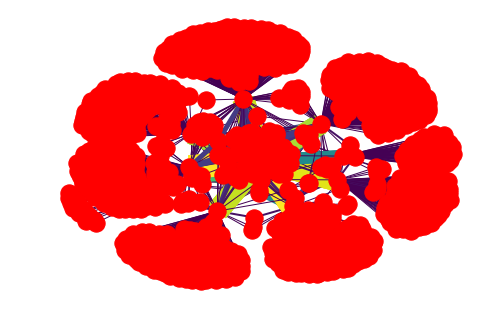

In [410]:
#draw actor and season graph
characters_season = make_draw_graph("Actors and Season", list(sf_cast_group.Actor.values) + list(sf_cast_group.season.values),sf_cast_group, False)

<h3> Projected Graph: Actor to Season </h3>

First, let's project the actor using the season value.

In [411]:
character_graph = bi.weighted_projected_graph(characters_season, list(sf_cast_group.Actor.values), ratio=False)

We see that George, Jerry, Elaine, and Kramer are central to the network, as we would expect.  Other important characters are Newman, Jerry's parents and Jerry's Uncle Leo, and George's parents.

In [412]:
centrality_measures(character_graph) #takes awhile to run

Number of Nodes:
1158

Number of Edges:
120325

Degree:
[('Jason Alexander', 1157), ('Jerry Seinfeld', 1157), ('Julia Louis-Dreyfus', 1157), ('Michael Richards', 1157), ('Wayne Knight', 1092), ('Liz Sheridan', 1055), ('Len Lesser', 1035), ('Barney Martin', 985), ('Estelle Harris', 985), ('Jerry Stiller', 985)]

Closeness:
[('Jason Alexander', 1.0), ('Jerry Seinfeld', 1.0), ('Julia Louis-Dreyfus', 1.0), ('Michael Richards', 1.0), ('Wayne Knight', 0.9468085106382979), ('Liz Sheridan', 0.9189833200953137), ('Len Lesser', 0.9046129788897577), ('Barney Martin', 0.8705793829947329), ('Estelle Harris', 0.8705793829947329), ('Jerry Stiller', 0.8705793829947329)]

Betweenness:
[('Jason Alexander', 0.056323838548247226), ('Jerry Seinfeld', 0.056323838548247226), ('Julia Louis-Dreyfus', 0.056323838548247226), ('Michael Richards', 0.056323838548247226), ('Wayne Knight', 0.04254707389386355), ('Liz Sheridan', 0.040616403262133595), ('Len Lesser', 0.035426396987549555), ('Barney Martin', 0.027383543

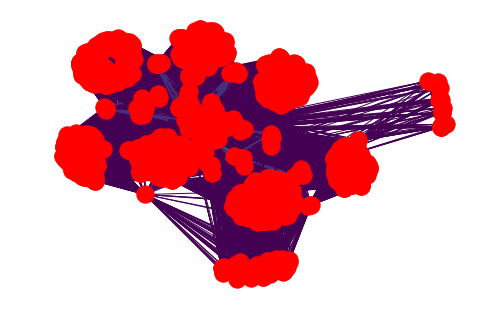

In [413]:
make_draw_projected_graph(character_graph, False)

<h3> Projected Graph: Season</h3>

In [414]:
season_graph = bi.weighted_projected_graph(characters_season, list(sf_cast_group.season.values), ratio=False)
season_graph = list(nx.connected_component_subgraphs(season_graph))[0]

There were 9 total seasons.  Based on the actors, there is a strong relationship between seasons 6, 7, 8, and 9, and to a lesser extent, 5.  Other seasons are more disconnected,particularly season 1, which has relatively weak links to the other seasons.

In [415]:
centrality_measures(season_graph) #takes awhile to run

Number of Nodes:
9

Number of Edges:
36

Degree:
[('S01', 8), ('S02', 8), ('S03', 8), ('S04', 8), ('S05', 8), ('S06', 8), ('S07', 8), ('S08', 8), ('S09', 8)]

Closeness:
[('S01', 1.0), ('S02', 1.0), ('S03', 1.0), ('S04', 1.0), ('S05', 1.0), ('S06', 1.0), ('S07', 1.0), ('S08', 1.0), ('S09', 1.0)]

Betweenness:
[('S01', 0.0), ('S02', 0.0), ('S03', 0.0), ('S04', 0.0), ('S05', 0.0), ('S06', 0.0), ('S07', 0.0), ('S08', 0.0), ('S09', 0.0)]

Eigenvector:
[('S01', 0.33333333333333337), ('S02', 0.33333333333333337), ('S03', 0.33333333333333337), ('S04', 0.33333333333333337), ('S05', 0.33333333333333337), ('S06', 0.33333333333333337), ('S07', 0.33333333333333337), ('S08', 0.33333333333333337), ('S09', 0.33333333333333337)]

Pagerank:
[('S08', 0.1434942043226922), ('S07', 0.1318409095299596), ('S06', 0.13082253911668065), ('S09', 0.13079574454678747), ('S05', 0.12284040304997577), ('S04', 0.1159864868159047), ('S03', 0.08670297886058641), ('S02', 0.07946020473082635), ('S01', 0.05805652902658701)

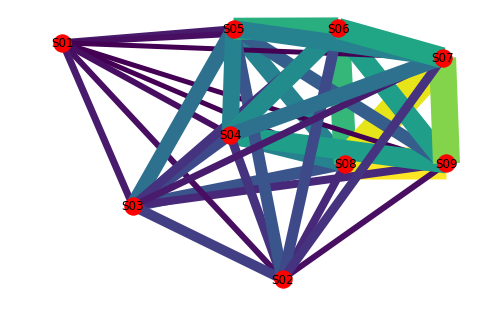

In [416]:
make_draw_projected_graph(season_graph, True)

<h3> Island Method</h3>

Let's pair down each of the projected graphs using the island method to get a better look.

In [417]:
#users
character_island = island_method(character_graph)

An edge weight greater than 1 takes the network down from 1158 nodes to 123.  As the weights increase, we see the central characters are in fact central to the network.

In [418]:
print_island_info(character_island)

Threshold, Nodes, Edges, Number of Connected Components
1 123 2007 1
2 34 342 1
3 23 169 1
4 15 75 1
5 11 49 1
6 7 19 1
7 5 10 1
8 4 6 1


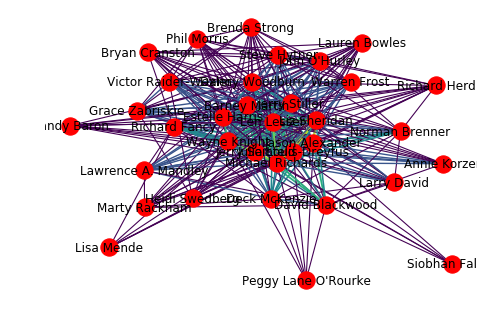

In [419]:
show_island_graphs(character_island,1,True)

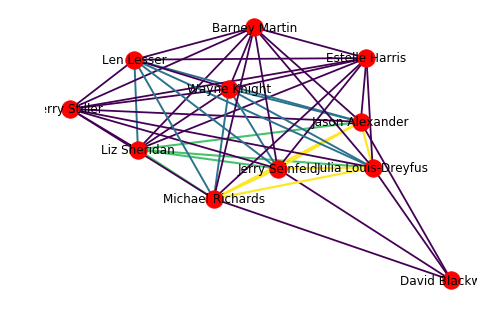

In [420]:
show_island_graphs(character_island,4,True)

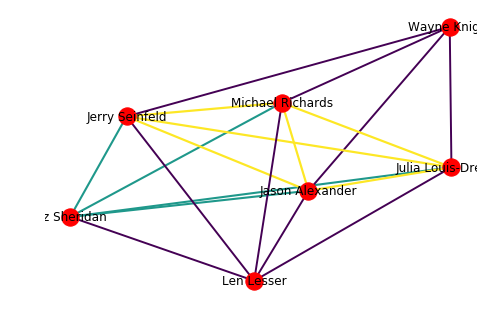

In [421]:
show_island_graphs(character_island,5,True)

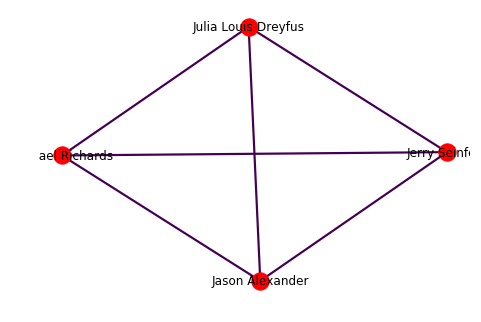

In [422]:
show_island_graphs(character_island,7,True)

In the end, we are left with the four main characters.

Now let's look at season.

In [423]:
## season
season_island = island_method(season_graph)

The seasons are reduced from 9 to 8, 6, 5, and 3.  As observed above, seasons 6, 7, 8, and 9 are strongly related and are at the center of the network.

In [424]:
print "Threshold, Nodes, Edges, Number of Connected Components"
for i in season_island:
    print i[0], nx.number_of_nodes(i[1]), nx.number_of_edges(i[1]), nx.number_connected_components(i[1])

Threshold, Nodes, Edges, Number of Connected Components
5 9 33 1
10 8 20 1
15 6 13 1
20 5 6 1
25 3 3 1
30 3 2 1


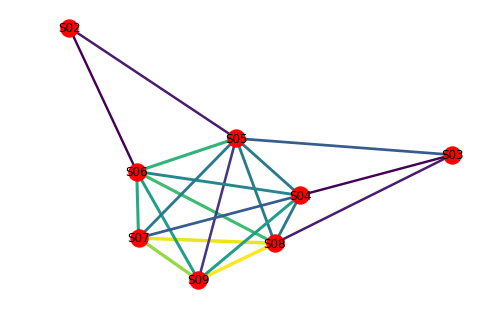

In [425]:
show_island_graphs(season_island,1,True)

<h2>2. Character by Scene Number</h2>

Now let's look at the relationship among characters by the scenes they share together.

In [426]:
sf_dialgoue_sub.head(5)

,Character,Dialogue,DialogueIndex,SEID,SceneNum
0,JERRY,Do you know what this is all about? Do you kno...,1,S01E00,S01E00_1
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1,S01E00,S01E00_2
2,GEORGE,Are you through?,2,S01E00,S01E00_2
3,JERRY,"You do of course try on, when you buy?",3,S01E00,S01E00_2
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",4,S01E00,S01E00_2


In [427]:
#group data by scene
sf_dialgoue_sub_group = sf_dialgoue_sub.groupby(['Character','SceneNum'], as_index=False).count()
sf_dialgoue_sub_group  = sf_dialgoue_sub_group [['Character','SceneNum', 'SEID']]
sf_dialgoue_sub_group.columns = ['Character','SceneNum', 'Counts']

In [428]:
sf_dialgoue_sub_group.head(5)

,Character,SceneNum,Counts
0,KRUGER,S09E10_18,1
1,accompanies assorted shots of working-man Kramer,S08E03_9,1
2,"to figuring out what is going on here, when t...",S04E17_8,1
3,"""SALMAN""",S04E19_13,3
4,"""SALMAN""",S04E19_13,1


We see below that there are some character/scenes that are not connected to anything else.  These are probably passing or transitional scenes.

As this graph is hard to see in detail, let's allow for more detailed exploration.

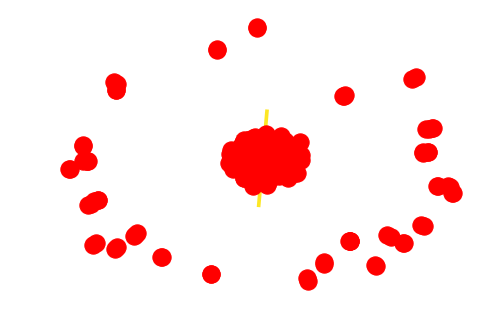

In [429]:
#draw graph
character_scene = make_draw_graph("Characters and Scene", list(sf_dialgoue_sub_group.Character.values) + list(sf_dialgoue_sub_group.SceneNum.values),sf_dialgoue_sub_group, False)

Below one can explore any scene from any episode and any season and look at the network based on characters in that scene.  As scenes can be very short, this is done at the episode level as well.

In [430]:
#split by scene
sf_dialgoue_sub_group_split = pd.DataFrame(sf_dialgoue_sub_group['SceneNum'].str.split("E").tolist(), columns = ['season','episode'])
sf_dialgoue_sub_group_split.head(5)

sf_dialgoue_sub_group_exp = sf_dialgoue_sub_group.join(sf_dialgoue_sub_group_split)
sf_dialgoue_sub_group_exp.head(5)

sf_dialgoue_sub_group_split2 = pd.DataFrame(sf_dialgoue_sub_group_exp['episode'].str.split("_").tolist(), columns = ['Episode2','scene'])
sf_dialgoue_sub_group_split2.head(5)

sf_dialgoue_sub_group_final = sf_dialgoue_sub_group_exp.join(sf_dialgoue_sub_group_split2)
sf_dialgoue_sub_group_final.head(5)


,Character,SceneNum,Counts,season,episode,Episode2,scene
0,KRUGER,S09E10_18,1,S09,10_18,10,18
1,accompanies assorted shots of working-man Kramer,S08E03_9,1,S08,03_9,03,9
2,"to figuring out what is going on here, when t...",S04E17_8,1,S04,17_8,17,8
3,"""SALMAN""",S04E19_13,3,S04,19_13,19,13
4,"""SALMAN""",S04E19_13,1,S04,19_13,19,13


In [431]:
#group data at episode level
sf_dialgoue_sub_group_episode = sf_dialgoue_sub.groupby(['Character','SEID'], as_index=False).count()
sf_dialgoue_sub_group_episode  = sf_dialgoue_sub_group_episode[['Character','SEID','SceneNum']]
sf_dialgoue_sub_group_episode.columns = ['Character','SEID', 'Counts']
sf_dialgoue_sub_group_episode.head(5)

,Character,SEID,Counts
0,KRUGER,S09E10,1
1,accompanies assorted shots of working-man Kramer,S08E03,1
2,"to figuring out what is going on here, when t...",S04E17,1
3,"""SALMAN""",S04E19,3
4,"""SALMAN""",S04E19,1


As an example of detailed exploration, below are networks of a scene from the finale and the finale as a whole using functions that were defined previously.

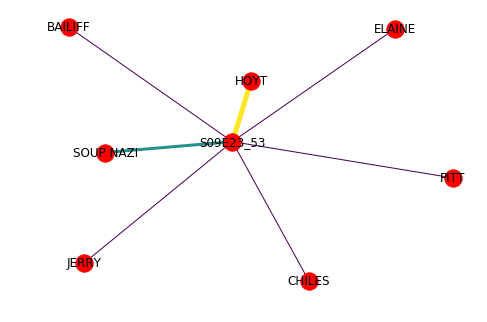

In [432]:
#finale scenes
character_scene_graph(sf_dialgoue_sub_group_final,"S09","23", "53", True)

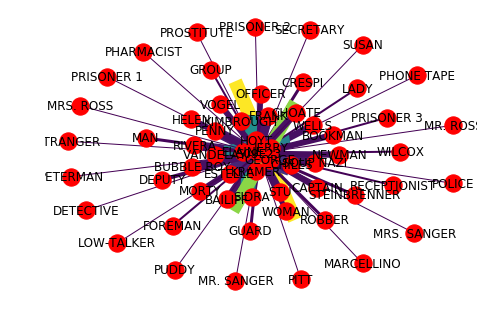

In [433]:
#whole finale
character_episode_graph(sf_dialgoue_sub_group_episode,"S09E23", True)

<h3> Projected Graph: Character to Scene</h3>

As the above full graph is difficult to interpret in whole, let's project using character.  Below we see that (as we expect), Jery, George, Elaine, and Kramer are central.  Newman is also central as Jerry's parents, George's wife, and George's dad.  Also central are "woman" and "man", probably passing characters that do not refer to the same woman or man, but these types of characters occur enough and are grouped together to show up here.

In [434]:
character_scene_graph_proj = bi.weighted_projected_graph(character_scene, list(sf_dialgoue_sub_group.Character.values), ratio=False)

In [435]:
#nx.write_gexf(character_scene_graph_proj, 'character_scene_graph_proj.gexf')

In [436]:
centrality_measures(character_scene_graph_proj) #takes awhile to run

Number of Nodes:
1247

Number of Edges:
5493

Degree:
[('JERRY', 790), ('GEORGE', 693), ('ELAINE', 655), ('KRAMER', 607), ('JERRY ', 91), ('NEWMAN', 84), ('WOMAN', 84), ('MAN', 79), ('MORTY', 74), ('SUSAN', 74)]

Closeness:
[('JERRY', 0.7200000786831586), ('GEORGE', 0.6788215646510195), ('ELAINE', 0.6638644793282006), ('KRAMER', 0.6459813790054507), ('JERRY ', 0.4995918913311714), ('NEWMAN', 0.4989554685396666), ('WOMAN', 0.4981094228109007), ('MORTY', 0.49684572025831497), ('GEORGE ', 0.495797522536251), ('FRANK', 0.49517072415124946)]

Betweenness:
[('JERRY', 0.29695338734359367), ('GEORGE', 0.2792132762253886), ('ELAINE', 0.22483592424865878), ('KRAMER', 0.20049918848202178), ('NEWMAN', 0.006965499433055013), ('MORTY', 0.006542993944841277), ('JERRY ', 0.0061408950101195054), ('MAN', 0.005991448766686579), ('ELAINE ', 0.005034094293925), ('GEORGE ', 0.00468205121023861)]

Eigenvector:
[('JERRY', 0.38101457433569225), ('GEORGE', 0.3321655169514927), ('ELAINE', 0.3277372511815577), ('

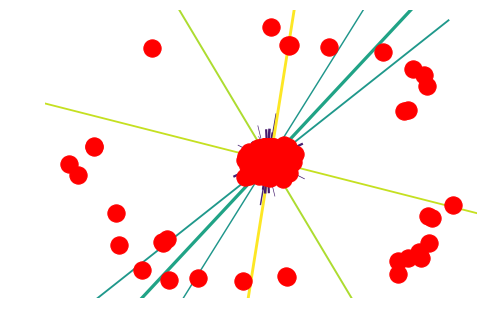

In [437]:
make_draw_projected_graph(character_scene_graph_proj, False)

Here is the above graph visualized in Gephi.

In [438]:
#gephi visualization here

<h3>Island</h3>

Let's use the island method to reduce the noise.  The first thresholding reduces from 1247 nodes to 551, and the second reduces that to 4 (our four main chracters).  Clearly, there are lots of characters in the show, but they are mostly fleeting, passing, and revolve around a relationship to Jerry, George, Elaine, and Kramer.  The strongest relationship is between Jerry and George.

In [439]:
#users
character_scene_island = island_method(character_scene_graph_proj)
print_island_info(character_scene_island)

Threshold, Nodes, Edges, Number of Connected Components
1 551 1427 3
171 4 6 1
341 4 6 1
511 4 3 1
681 4 3 1
851 2 1 1


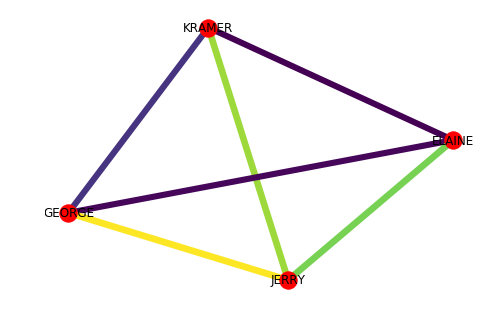

In [440]:
show_island_graphs(character_scene_island,1,True)

<h2> 3. Directors and Season </h2>

How do the directors and seasons relate?

In [441]:
sf_metadata.head(5)

,AirDate,Director,Episode,SEID,Season,Title
0,"July 5, 1989",Art Wolff,1,S01E00,1,"Good News, Bad News"
1,"May 31, 1990",Tom Cherones,1,S01E01,1,The Stakeout
2,"June 7, 1990",Tom Cherones,2,S01E02,1,The Robbery
3,"June 14, 1990",Tom Cherones,3,S01E03,1,Male Unbonding
4,"June 21, 1990",Tom Cherones,4,S01E04,1,The Stock Tip


In [442]:
sf_metadata_group = sf_metadata.groupby(['Director','Season'], as_index=False).count()
sf_metadata_group = sf_metadata_group[['Director','Season', 'SEID']]
sf_metadata_group.columns = ['Director','Season', 'Counts']
sf_metadata_group.head(5)

,Director,Season,Counts
0,Andy Ackerman,6,21
1,Andy Ackerman,7,24
2,Andy Ackerman,8,21
3,Andy Ackerman,9,21
4,Art Wolff,1,1


We see two distinct groups.  The first is a larger group around seasons 1-5.  The second group is much smaller around seasons 6-9.  While there were 5 directors in the first five seasons, there were only two different directors in 6-9.  This helps explain why 6-9 are grouped much more closely together in the actor/character to season analysis.  This is made even more obvious in the below projected graphs.

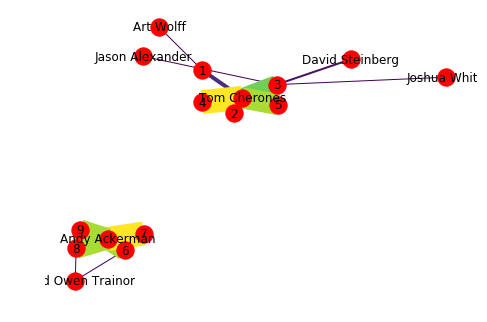

In [443]:
#draw actor and season graph
directors_season = make_draw_graph("Directors and Season", list(sf_metadata_group.Director.values) + list(sf_metadata_group.Season.values),sf_metadata_group, True)

Number of Nodes:
7

Number of Edges:
8

Degree:
[('Tom Cherones', 4), ('David Steinberg', 3), ('Jason Alexander', 3), ('Joshua White', 3), ('Andy Ackerman', 1), ('Art Wolff', 1), ('David Owen Trainor', 1)]

Closeness:
[('Tom Cherones', 0.6666666666666666), ('David Steinberg', 0.5333333333333333), ('Jason Alexander', 0.5333333333333333), ('Joshua White', 0.5333333333333333), ('Art Wolff', 0.38095238095238093), ('Andy Ackerman', 0.16666666666666666), ('David Owen Trainor', 0.16666666666666666)]

Betweenness:
[('Tom Cherones', 0.2), ('Andy Ackerman', 0.0), ('Art Wolff', 0.0), ('David Owen Trainor', 0.0), ('David Steinberg', 0.0), ('Jason Alexander', 0.0), ('Joshua White', 0.0)]

Eigenvector:
[('Tom Cherones', 0.5235630239710829), ('David Steinberg', 0.48204443864828317), ('Jason Alexander', 0.48204443864828317), ('Joshua White', 0.48204443864828317), ('Art Wolff', 0.1696503387049744), ('Andy Ackerman', 2.4826834530544244e-06), ('David Owen Trainor', 2.4826834530544244e-06)]

Pagerank:
[('

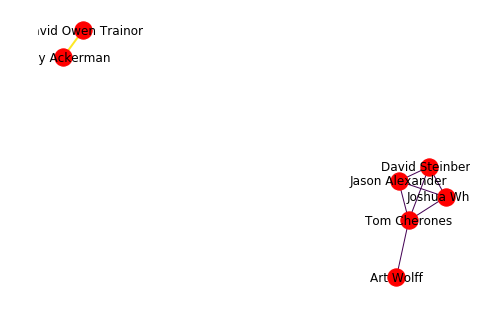

In [444]:
#projected director
director_graph = bi.weighted_projected_graph(directors_season, list(sf_metadata_group.Director.values), ratio=False)
centrality_measures(director_graph) #takes awhile to run
make_draw_projected_graph(director_graph, True)

Number of Nodes:
9

Number of Edges:
16

Degree:
[(1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (6, 3), (7, 3), (8, 3), (9, 3)]

Closeness:
[(1, 0.5), (2, 0.5), (3, 0.5), (4, 0.5), (5, 0.5), (6, 0.375), (7, 0.375), (8, 0.375), (9, 0.375)]

Betweenness:
[(1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0)]

Eigenvector:
[(1, 0.4472135954430211), (2, 0.4472135954430211), (3, 0.4472135954430211), (4, 0.4472135954430211), (5, 0.4472135954430211), (6, 7.978557153034853e-06), (7, 7.978557153034853e-06), (8, 7.978557153034853e-06), (9, 7.978557153034853e-06)]

Pagerank:
[(6, 0.12489850979595186), (8, 0.12489850979595185), (1, 0.1111111111111111), (2, 0.1111111111111111), (3, 0.1111111111111111), (4, 0.1111111111111111), (5, 0.1111111111111111), (7, 0.09732371242627035), (9, 0.09732371242627033)]


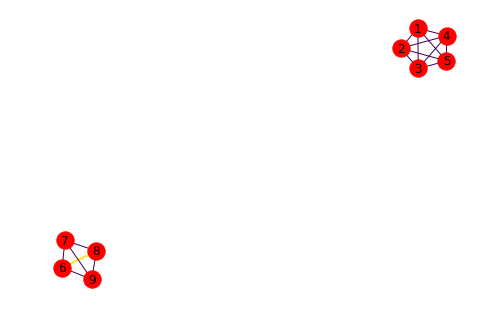

In [445]:
#projected season
director_season_graph = bi.weighted_projected_graph(directors_season, list(sf_metadata_group.Season.values), ratio=False)
centrality_measures(director_season_graph) #takes awhile to run
make_draw_projected_graph(director_season_graph, True)

<h2>4. Writers and Season </h2>

What about writers and season?

In [446]:
sf_writers.head(5)

,Writers,SEID
0,Larry David,S01E00
1,Jerry Seinfeld,S01E00
2,Larry David,S01E01
3,Jerry Seinfeld,S01E01
4,Matt Goldman,S01E02


In [447]:
#reference: https://pandas.pydata.org/pandas-docs/stable/10min.html
sf_writers_episode = pd.DataFrame(sf_writers['SEID'].str.split("E").tolist(), columns = ['season','episode'])
sf_writers = sf_writers.join(sf_writers_episode)
sf_writers.head(5)

,Writers,SEID,season,episode
0,Larry David,S01E00,S01,00
1,Jerry Seinfeld,S01E00,S01,00
2,Larry David,S01E01,S01,01
3,Jerry Seinfeld,S01E01,S01,01
4,Matt Goldman,S01E02,S01,02


In [448]:
sf_writers_group = sf_writers.groupby(['Writers','season'], as_index=False).count()
sf_writers_group = sf_writers_group[['Writers','season', 'episode']]
sf_writers_group.columns = ['Writers','season', 'Counts']
sf_writers_group.head(5)

,Writers,season,Counts
0,Alec Berg,S06,3
1,Alec Berg,S07,3
2,Alec Berg,S08,3
3,Alec Berg,S09,5
4,Andy Cowan,S05,1


Unlike the directors, the writers/season graph form one cluster, and there are many more writers than directors.

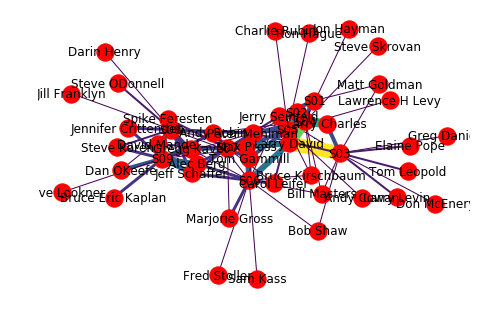

In [449]:
#draw actor and season graph
writers_season = make_draw_graph("Writers and Season", list(sf_writers_group.Writers.values) + list(sf_writers_group.season.values),sf_writers_group, True)

Number of Nodes:
39

Number of Edges:
356

Degree:
[('Peter Mehlman', 38), ('Larry David', 35), ('Andy Robin', 32), ('Jerry Seinfeld', 30), ('Max Pross', 28), ('Tom Gammill', 28), ('Alec Berg', 25), ('Gregg Kavet', 25), ('Jeff Schaffer', 25), ('Bill Masters', 24)]

Closeness:
[('Peter Mehlman', 1.0), ('Larry David', 0.926829268292683), ('Andy Robin', 0.8636363636363636), ('Jerry Seinfeld', 0.8260869565217391), ('Max Pross', 0.7916666666666666), ('Tom Gammill', 0.7916666666666666), ('Alec Berg', 0.7450980392156863), ('Gregg Kavet', 0.7450980392156863), ('Jeff Schaffer', 0.7450980392156863), ('Bill Masters', 0.7307692307692307)]

Betweenness:
[('Peter Mehlman', 0.1363692297902824), ('Larry David', 0.09548323100954682), ('Andy Robin', 0.05443466364518998), ('Jerry Seinfeld', 0.05249323144059985), ('Max Pross', 0.028085929401718876), ('Tom Gammill', 0.028085929401718876), ('Bill Masters', 0.026092257671205044), ('Larry Charles', 0.023847908058434376), ('Bob Shaw', 0.0182076813655761), ('Al

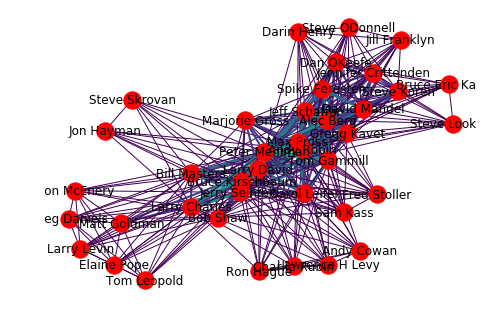

In [450]:
#projected writers
writer_graph = bi.weighted_projected_graph(writers_season, list(sf_writers_group.Writers.values), ratio=False)
centrality_measures(writer_graph) #takes awhile to run
make_draw_projected_graph(writer_graph, True)

In [451]:
#island on proejcted writers
writer_island = island_method(writer_graph)
print_island_info(writer_island)

Threshold, Nodes, Edges, Number of Connected Components
1 21 120 1
2 15 60 1
3 10 23 1
4 4 5 1
5 4 4 1
6 3 2 1


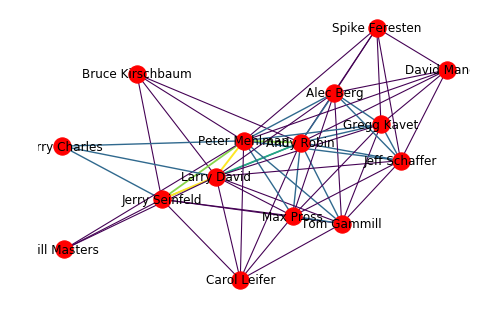

In [452]:
show_island_graphs(writer_island,1,True)

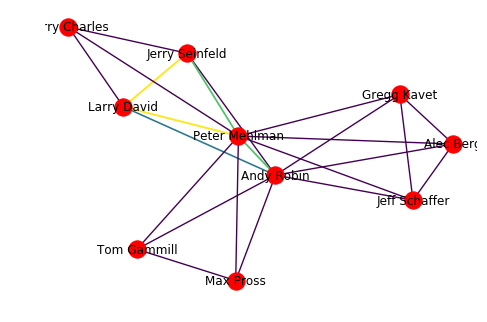

In [453]:
show_island_graphs(writer_island,2,True)

The four main writers are: Larry David (who originated the show with Jerry), Jerry Seinfeld, Peter Mehlman, and Andy Robin.  Peter Mehlman and Larry David are the most central writers in the network.

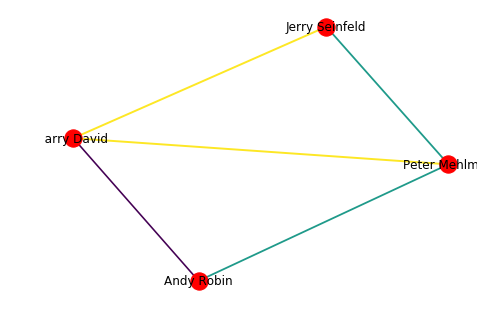

In [454]:
show_island_graphs(writer_island,3,True)

Looking at writers to season, we again see that seasons 6-9 form a strong link based on writers.  As we would expect the writers to have large control over which characters/actors show up, it shouldn't surprise us that having the same writers in 6-9 tends towards having the same characters in 6-9.

Number of Nodes:
9

Number of Edges:
35

Degree:
[('S02', 8), ('S03', 8), ('S04', 8), ('S05', 8), ('S06', 8), ('S07', 8), ('S09', 8), ('S01', 7), ('S08', 7)]

Closeness:
[('S02', 1.0), ('S03', 1.0), ('S04', 1.0), ('S05', 1.0), ('S06', 1.0), ('S07', 1.0), ('S09', 1.0), ('S01', 0.8888888888888888), ('S08', 0.8888888888888888)]

Betweenness:
[('S02', 0.00510204081632653), ('S03', 0.00510204081632653), ('S04', 0.00510204081632653), ('S05', 0.00510204081632653), ('S06', 0.00510204081632653), ('S07', 0.00510204081632653), ('S09', 0.00510204081632653), ('S01', 0.0), ('S08', 0.0)]

Eigenvector:
[('S02', 0.34074955749202834), ('S03', 0.34074955749202834), ('S04', 0.34074955749202834), ('S05', 0.34074955749202834), ('S06', 0.34074955749202834), ('S07', 0.34074955749202834), ('S09', 0.34074955749202834), ('S01', 0.30596419192685614), ('S08', 0.30596419192685614)]

Pagerank:
[('S06', 0.1537352784541297), ('S07', 0.1503520305707618), ('S05', 0.125511222616213), ('S09', 0.11524573314845227), ('S08',

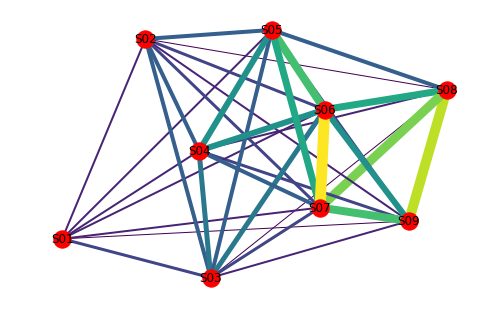

In [455]:
#projected season by writers
writer_season_graph = bi.weighted_projected_graph(writers_season, list(sf_writers_group.season.values), ratio=False)
centrality_measures(writer_season_graph) #takes awhile to run
make_draw_projected_graph(writer_season_graph, True)

<h2>5. Writers, Directors, and Cast</h2>

Finally, let's look at the relationship between writers, directors, and cast directly using the SEID to join.

In [456]:
#join writers, directors, actors together by SEID
sf_all_people = sf_metadata[['Director', 'SEID']]
sf_writers_sub = sf_writers[['Writers','SEID']]
sf_all_people = sf_all_people.set_index('SEID').join(sf_writers_sub.set_index('SEID'), on='SEID', how='outer')
sf_cast_sub = sf_cast[['Actor', 'SEID']]
sf_all_people = sf_all_people.join(sf_cast_sub.set_index('SEID'), on='SEID', how='outer')
sf_all_people.head(5)

,Director,Writers,Actor
SEID,,,
S01E00,Art Wolff,Larry David,Jerry Seinfeld
S01E00,Art Wolff,Larry David,Jason Alexander
S01E00,Art Wolff,Larry David,Michael Richards
S01E00,Art Wolff,Larry David,Lee Garlington
S01E00,Art Wolff,Larry David,Pamela Brull


In [457]:
#director to writer SNA
director_writer_group = sf_all_people.groupby(['Director','Writers'], as_index=False).count()
director_writer_group = director_writer_group[['Director','Writers', 'Actor']]
director_writer_group.columns = ['Director','Writers', 'Counts']
director_writer_group.head(5)

,Director,Writers,Counts
0,Andy Ackerman,Alec Berg,215
1,Andy Ackerman,Andy Robin,144
2,Andy Ackerman,Bill Masters,9
3,Andy Ackerman,Bob Shaw,9
4,Andy Ackerman,Bruce Eric Kaplan,47


While the first graph below is a little difficult to read, by increasing the counts threshold, we can see that the strongest director-writer relationship exists between Tom Cherones and Larry David.  This is interesting as Tom Cherones only directed in seasons 1-5.  However, Andy Ackerman (6-9) has a strong relationship with several writers, including Larry David.

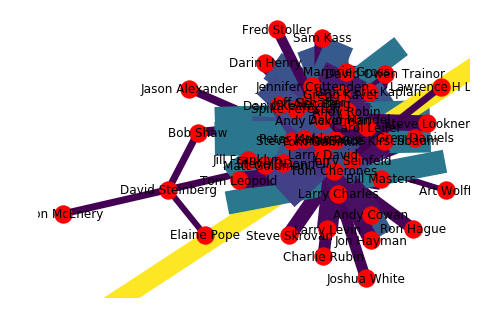

In [458]:
#draw actor and season graph
director_writer = make_draw_graph("Directors and Writers", list(director_writer_group.Director.values) + list(director_writer_group.Writers.values),director_writer_group, True)

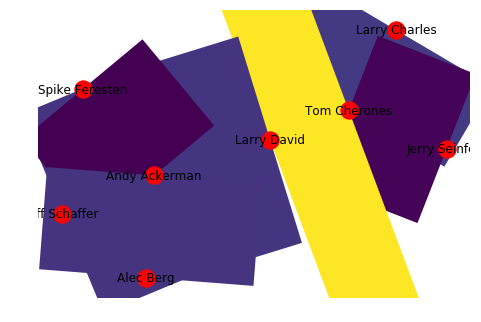

In [459]:
director_writer_sub = director_writer_group[director_writer_group['Counts']>150]
director_writer_sub_graph = make_draw_graph("Directors and Writers", list(director_writer_sub.Director.values) + list(director_writer_sub.Writers.values),director_writer_sub, True)

In [460]:
director_writer_sub = director_writer_group[director_writer_group['Counts']>200]
director_writer_sub.head(10)

,Director,Writers,Counts
0,Andy Ackerman,Alec Berg,215
12,Andy Ackerman,Jeff Schaffer,215
16,Andy Ackerman,Larry David,216
48,Tom Cherones,Larry Charles,222
49,Tom Cherones,Larry David,545


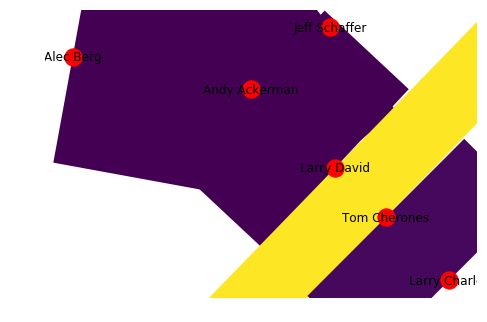

In [461]:
director_writer_sub_graph = make_draw_graph("Directors and Writers", list(director_writer_sub.Director.values) + list(director_writer_sub.Writers.values),director_writer_sub, True)

Now let's look at writer and cast.  The first few graphs produce an un-interpretable mess.

In [484]:
#writer to cast
writer_cast_group = sf_all_people.groupby(['Writers','Actor'], as_index=False).count()
writer_cast_group = writer_cast_group [['Writers', 'Actor','Director']]
writer_cast_group.columns = ['Writers','Actor', 'Counts']
writer_cast_group.head(5)

,Writers,Actor,Counts
0,Alec Berg,Adrian Sparks,1
1,Alec Berg,Alison Martin,1
2,Alec Berg,Amanda Peet,1
3,Alec Berg,Amit Itelman,1
4,Alec Berg,Angela Featherstone,1


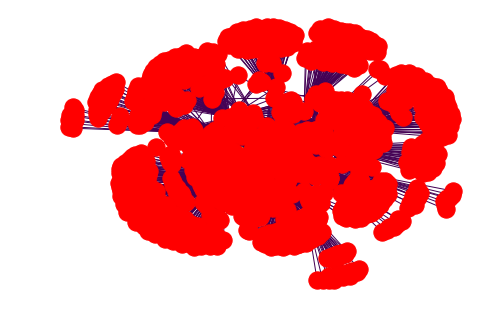

In [485]:
#draw writer and cast
writer_cast = make_draw_graph("Writers and Cast", list(writer_cast_group.Writers.values) + list(writer_cast_group.Actor.values),writer_cast_group, False)

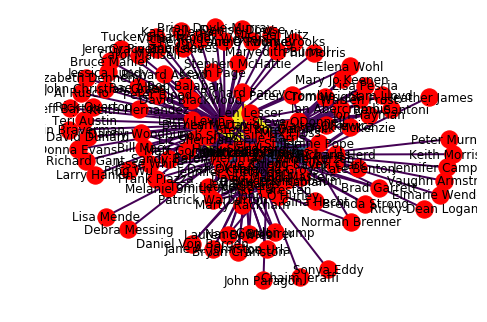

In [464]:
writer_cast_sub = writer_cast_group[writer_cast_group['Counts']>1]
writer_cast_sub_graph = make_draw_graph("Writers and Cast", list(writer_cast_sub.Writers.values) + list(writer_cast_sub.Actor.values),writer_cast_sub, True)

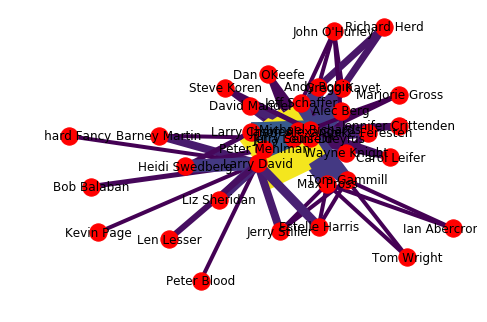

In [465]:
writer_cast_sub = writer_cast_group[writer_cast_group['Counts']>3]
writer_cast_sub_graph = make_draw_graph("Writers and Cast", list(writer_cast_sub.Writers.values) + list(writer_cast_sub.Actor.values),writer_cast_sub, True)

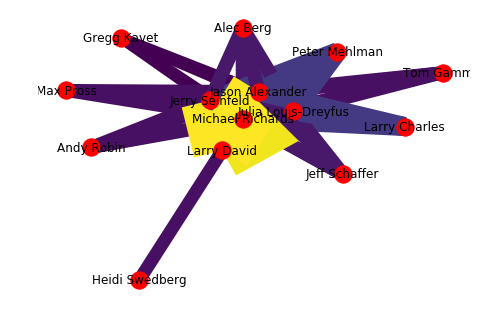

In [466]:
writer_cast_sub = writer_cast_group[writer_cast_group['Counts']>10]
writer_cast_sub_graph = make_draw_graph("Writers and Cast", list(writer_cast_sub.Writers.values) + list(writer_cast_sub.Actor.values),writer_cast_sub, True)

After inreasing the counts threshold, we can see some insights coming out of the noise.  In particular, we see that the main writer (Larry David), along with Peter Mehlman and Larry Charles, are strongly related to the four main characters.  Again, this is not surprising as the main writers should be related to the main characters.

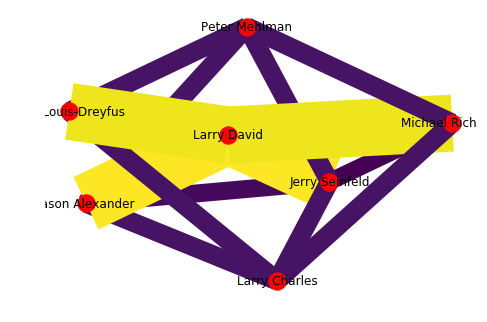

In [467]:
writer_cast_sub = writer_cast_group[writer_cast_group['Counts']>15]
writer_cast_sub_graph = make_draw_graph("Writers and Cast", list(writer_cast_sub.Writers.values) + list(writer_cast_sub.Actor.values),writer_cast_sub, True)

Now we look at the relationship between director and cast.

In [468]:
#director to cast
director_cast_group = sf_all_people.groupby(['Director','Actor'], as_index=False).count()
director_cast_group = director_cast_group [['Director','Actor','Writers']]
director_cast_group.columns = ['Director','Actor', 'Counts']
director_cast_group.head(5)

,Director,Actor,Counts
0,Andy Ackerman,A.J. Langer,2
1,Andy Ackerman,Adelaide Miller,2
2,Andy Ackerman,Adrian Sparks,2
3,Andy Ackerman,Akane Nelson,3
4,Andy Ackerman,Al White,1


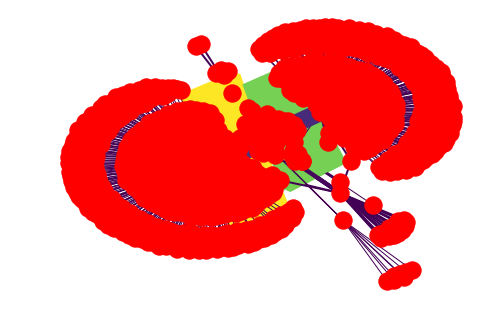

In [469]:
#draw director and cast
director_cast = make_draw_graph("Director and Cast", list(director_cast_group.Director.values) + list(director_cast_group.Actor.values),director_cast_group, False)

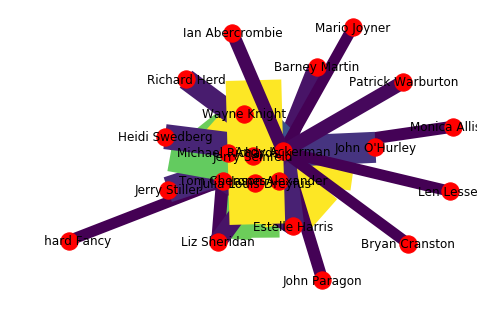

In [470]:
director_cast_sub = director_cast_group[director_cast_group['Counts']>10]
director_cast_sub_graph = make_draw_graph("Directors and Cast", list(director_cast_sub.Director.values) + list(director_cast_sub.Actor.values),director_cast_sub, True)

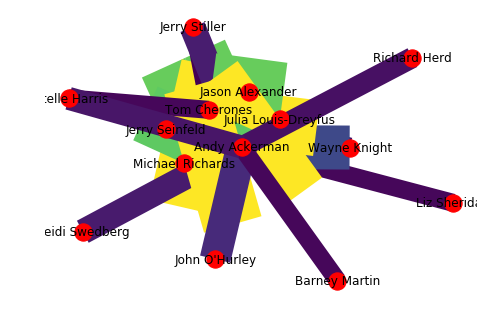

In [471]:
director_cast_sub = director_cast_group[director_cast_group['Counts']>15]
director_cast_sub_graph = make_draw_graph("Directors and Cast", list(director_cast_sub.Director.values) + list(director_cast_sub.Actor.values),director_cast_sub, True)

We see that central directors Tom Cherones and Andy Ackerman are connected to the four main chracters strongly.  Other important characters J Peterman, Newman, Susan, Jerry's parents, and George's parents.  Again, not surprising.

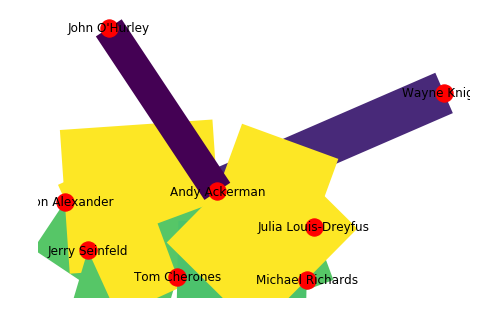

In [472]:
director_cast_sub = director_cast_group[director_cast_group['Counts']>30]
director_cast_sub_graph = make_draw_graph("Directors and Cast", list(director_cast_sub.Director.values) + list(director_cast_sub.Actor.values),director_cast_sub, True)

These relationships are made more obvious by using projections.

For directors (using writers), Andy Ackerman and Tom Cherones have the strongest relationship.



Number of Nodes:
7

Number of Edges:
11

Degree:
[('Tom Cherones', 6), ('Andy Ackerman', 5), ('Art Wolff', 3), ('David Steinberg', 3), ('David Owen Trainor', 2), ('Jason Alexander', 2), ('Joshua White', 1)]

Closeness:
[('Tom Cherones', 1.0), ('Andy Ackerman', 0.8571428571428571), ('Art Wolff', 0.6666666666666666), ('David Steinberg', 0.6666666666666666), ('David Owen Trainor', 0.6), ('Jason Alexander', 0.6), ('Joshua White', 0.5454545454545454)]

Betweenness:
[('Tom Cherones', 0.5), ('Andy Ackerman', 0.16666666666666666), ('Art Wolff', 0.0), ('David Owen Trainor', 0.0), ('David Steinberg', 0.0), ('Jason Alexander', 0.0), ('Joshua White', 0.0)]

Eigenvector:
[('Tom Cherones', 0.53097866504423), ('Andy Ackerman', 0.5004581136421644), ('Art Wolff', 0.38188529511665764), ('David Steinberg', 0.38188529511665764), ('David Owen Trainor', 0.2786988164130786), ('Jason Alexander', 0.2786988164130786), ('Joshua White', 0.14347304961141252)]

Pagerank:
[('Andy Ackerman', 0.30699785699283155), ('T

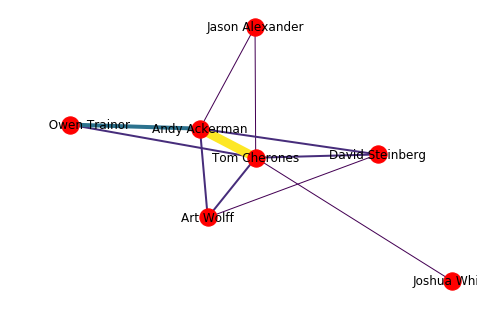

In [473]:
#projected directors on writer
director_writer_proj_graph = bi.weighted_projected_graph(director_writer, list(director_writer_group.Director.values), ratio=False)
centrality_measures(director_writer_proj_graph) #takes awhile to run
make_draw_projected_graph(director_writer_proj_graph, True)

For writers (on directors), Larry David and Andy Robin are most central.

Number of Nodes:
39

Number of Edges:
503

Degree:
[('Larry David', 38), ('Andy Robin', 37), ('Bill Masters', 37), ('Bruce Kirschbaum', 37), ('Carol Leifer', 37), ('Jerry Seinfeld', 37), ('Max Pross', 37), ('Peter Mehlman', 37), ('Tom Gammill', 37), ('Bob Shaw', 27)]

Closeness:
[('Larry David', 1.0), ('Andy Robin', 0.9743589743589743), ('Bill Masters', 0.9743589743589743), ('Bruce Kirschbaum', 0.9743589743589743), ('Carol Leifer', 0.9743589743589743), ('Jerry Seinfeld', 0.9743589743589743), ('Max Pross', 0.9743589743589743), ('Peter Mehlman', 0.9743589743589743), ('Tom Gammill', 0.9743589743589743), ('Bob Shaw', 0.7755102040816326)]

Betweenness:
[('Larry David', 0.05465465465465468), ('Andy Robin', 0.031657973763236945), ('Bill Masters', 0.031657973763236945), ('Bruce Kirschbaum', 0.031657973763236945), ('Carol Leifer', 0.031657973763236945), ('Jerry Seinfeld', 0.031657973763236945), ('Max Pross', 0.031657973763236945), ('Peter Mehlman', 0.031657973763236945), ('Tom Gammill', 0.03165

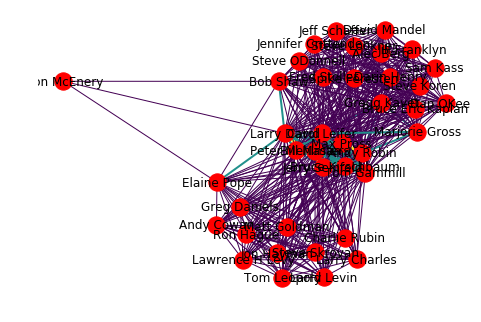

In [474]:
#projected writers on director
writer_director_proj_graph = bi.weighted_projected_graph(director_writer, list(director_writer_group.Writers.values), ratio=False)
centrality_measures(writer_director_proj_graph) #takes awhile to run
make_draw_projected_graph(writer_director_proj_graph, True)

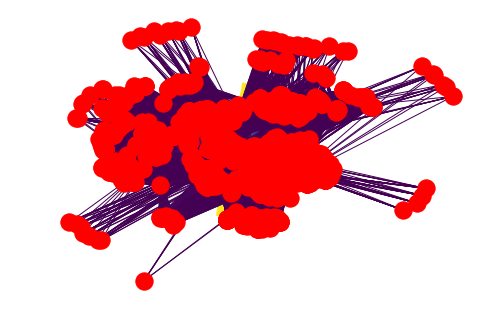

In [486]:
#projected cast on writer
cast_writer_proj_graph = bi.weighted_projected_graph(writer_cast, list(writer_cast_group.Actor.values), ratio=False)
#centrality_measures(cast_writer_proj_graph) #takes too long to run.
make_draw_projected_graph(cast_writer_proj_graph, False)

For cast (on writer), we see two distinct groups.

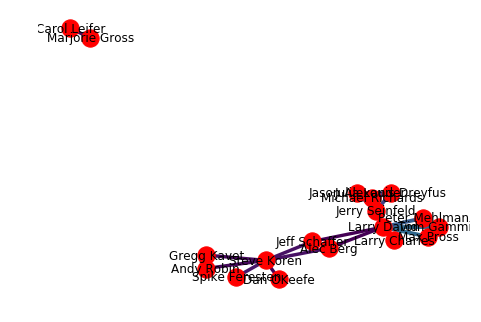

In [487]:
#island - cast by writer
cast_writer_island = island_method(cast_writer_proj_graph)
show_island_graphs(cast_writer_island,1,True)

Finally, let's combine writers, directors, and cast into a single graph.

In [477]:
#directors and writers
df_to_from = director_writer_group[['Writers','Director','Counts']]
df_to_from.columns = ['From','To' ,'Counts']
#print df_to_from.count() #59

#directors and cast
df_to_from_2 = director_cast_group
df_to_from_2.columns = ['From','To' ,'Counts']
#print df_to_from_2.count() #1237
df_to_from_all = df_to_from.append(df_to_from_2)

#writers and cast
df_to_from_3 = writer_cast_group
df_to_from_3.columns = ['From','To' ,'Counts']
#print df_to_from_3.count() #2505
df_to_from_all = df_to_from_all.append(df_to_from_3)


#print df_to_from_all.count()
df_to_from_all.head(5)

,From,To,Counts
0,Alec Berg,Andy Ackerman,215
1,Andy Robin,Andy Ackerman,144
2,Bill Masters,Andy Ackerman,9
3,Bob Shaw,Andy Ackerman,9
4,Bruce Eric Kaplan,Andy Ackerman,47


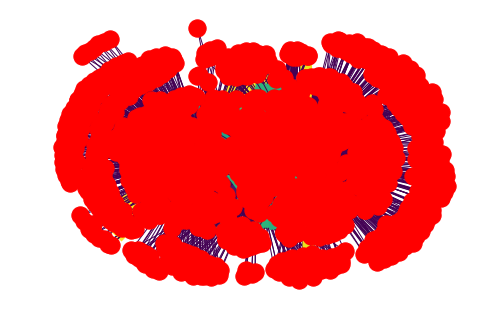

In [478]:
all_people_graph = make_draw_graph("Writer to Director to Cast", list(df_to_from_all.From.values) + list(df_to_from_all.To.values),df_to_from_all, False)

As this is difficult to see, We put it into Gephi for better visualization.

In [479]:
#nx.write_gexf(all_people_graph, 'all_people_graph.gexf')

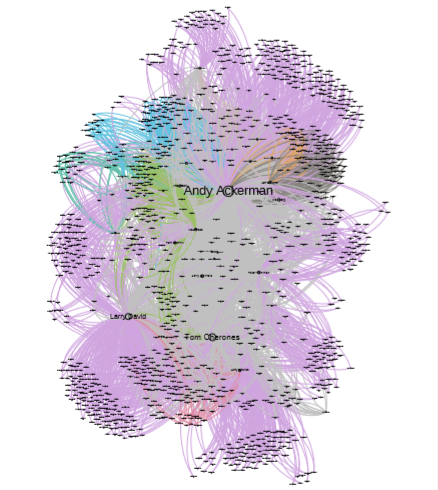

In [480]:
Image("all_people_graph_gephi.png")

<h2> Conclusion </h2>

Obviously un-ending details and depth could be explored with this data, but we have revealed obvious facts (e.g., Jerry, Kramer, George, and Elaine are central cast members) as well as some not so obvious facts (e.g., seasons 1-5 clustering vs. seasons 6-9, Larry David is the main writer, Andy Ackerman and Tom Cherones are the main directors).  We have also shown a variety of connections among the cast members, directors, and writers at the series, season, episode, and scene levels.  A much more detailed analysis is certainly worth pursuing.  What has been done here, while useful, is merely a starting point for further exploration of this great show by means of social network analysis.